## POS tagging using modified Viterbi

In this assignment we will apply techniques to improve Vanilla Viterbi Algorithm. Following are the steps followed:

1. Data Preparation:
    * Download and import universal tagset in nltk_data
    * Sample the dataset into training and validation datasets in a ratio of 95:5
2. Use of Plain vanilla Viterbi Algorithm and check accuracy.
3. Viterbi Modification-Technique I - approach:
    * Transition probability is considered in case of unknown words.
    * The above approach is modified to consider transition probability weighted by tag occurrence probability in training set.
4. Viterbi Modification-Technique II - approach:
     * Backoff to a rule based tagger in case of an unknown word.
     * The above technique is modified by using transition probability in approach 2 above if rule based tagger returns default noun tag ('NN').
5. The modified Viterbi algorithms are first tested on sampled test data for comparison.
6. The final algorithm and vanilla Viterbi Algorithm are the tested on full testing data for comparison.

### Data Preparation

In [136]:
#Importing libraries
import nltk
nltk.download('universal_tagset')

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package universal_tagset to
[nltk_data]     /home/parikshit.tomar/nltk_data...
[nltk_data]   Package universal_tagset is already up-to-date!


In [137]:
# reading the Treebank tagged sentences
nltk_data = list(nltk.corpus.treebank.tagged_sents(tagset='universal'))

In [138]:
# let's check some of the tagged data
print(nltk_data[:10])

[[('Pierre', 'NOUN'), ('Vinken', 'NOUN'), (',', '.'), ('61', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), (',', '.'), ('will', 'VERB'), ('join', 'VERB'), ('the', 'DET'), ('board', 'NOUN'), ('as', 'ADP'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('Nov.', 'NOUN'), ('29', 'NUM'), ('.', '.')], [('Mr.', 'NOUN'), ('Vinken', 'NOUN'), ('is', 'VERB'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Elsevier', 'NOUN'), ('N.V.', 'NOUN'), (',', '.'), ('the', 'DET'), ('Dutch', 'NOUN'), ('publishing', 'VERB'), ('group', 'NOUN'), ('.', '.')], [('Rudolph', 'NOUN'), ('Agnew', 'NOUN'), (',', '.'), ('55', 'NUM'), ('years', 'NOUN'), ('old', 'ADJ'), ('and', 'CONJ'), ('former', 'ADJ'), ('chairman', 'NOUN'), ('of', 'ADP'), ('Consolidated', 'NOUN'), ('Gold', 'NOUN'), ('Fields', 'NOUN'), ('PLC', 'NOUN'), (',', '.'), ('was', 'VERB'), ('named', 'VERB'), ('*-1', 'X'), ('a', 'DET'), ('nonexecutive', 'ADJ'), ('director', 'NOUN'), ('of', 'ADP'), ('this', 'DET'), ('British', 'ADJ'), ('industrial', 'ADJ'), ('

In [139]:
# Lets check length of data
print(len(nltk_data))

3914


In [140]:
#Split data in train and test set
train_set, test_set = train_test_split(nltk_data,train_size=0.95,test_size=0.05,random_state = 101)

In [141]:
# Lets see length of train and test split, also few train set data
print(len(train_set))
print(len(test_set))
print(train_set[1:10])

3718
196
[[('*', 'X'), ('Encouraging', 'VERB'), ('long-term', 'ADJ'), ('investing', 'NOUN'), ('.', '.')], [('Because', 'ADP'), ('of', 'ADP'), ('the', 'DET'), ('rulings', 'NOUN'), (',', '.'), ('the', 'DET'), ('Commerce', 'NOUN'), ('Department', 'NOUN'), ('will', 'VERB'), ('continue', 'VERB'), ('*-1', 'X'), ('to', 'PRT'), ('investigate', 'VERB'), ('complaints', 'NOUN'), ('*ICH*-2', 'X'), ('by', 'ADP'), ('U.S.', 'NOUN'), ('sweater', 'NOUN'), ('makers', 'NOUN'), ('that', 'ADP'), ('the', 'DET'), ('imports', 'NOUN'), ('are', 'VERB'), ('reaching', 'VERB'), ('the', 'DET'), ('U.S.', 'NOUN'), ('at', 'ADP'), ('unfairly', 'ADV'), ('low', 'ADJ'), ('prices', 'NOUN'), ('in', 'ADP'), ('violation', 'NOUN'), ('of', 'ADP'), ('the', 'DET'), ('U.S.', 'NOUN'), ('anti-dumping', 'ADJ'), ('act', 'NOUN'), ('.', '.')], [('What', 'PRON'), ('she', 'PRON'), ('did', 'VERB'), ('*T*-97', 'X'), ('was', 'VERB'), ('like', 'ADP'), ('*', 'X'), ('taking', 'VERB'), ('the', 'DET'), ('law', 'NOUN'), ('into', 'ADP'), ('your', '

In [142]:
# Getting list of train tagged words
train_tagged_words = [tup for sent in train_set for tup in sent]
len(train_tagged_words)

95547

In [143]:
# Getting list of test tagged words
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
len(test_tagged_words)

5129

In [144]:
# check some of the tagged words.
train_tagged_words[1:5]

[('confirmed', 'VERB'), ('the', 'DET'), ('filing', 'NOUN'), ('but', 'CONJ')]

In [145]:
# tokens 
tokens = [pair[0] for pair in train_tagged_words]
tokens[:30]

['Reliance',
 'confirmed',
 'the',
 'filing',
 'but',
 'would',
 "n't",
 'elaborate',
 '.',
 '*',
 'Encouraging',
 'long-term',
 'investing',
 '.',
 'Because',
 'of',
 'the',
 'rulings',
 ',',
 'the',
 'Commerce',
 'Department',
 'will',
 'continue',
 '*-1',
 'to',
 'investigate',
 'complaints',
 '*ICH*-2',
 'by']

In [146]:
# vocabulary
V = set(tokens)
print(len(V))

12100


In [147]:
# number of tags
tags = set([pair[1] for pair in train_tagged_words])
len(tags)

12

In [148]:
print(tags)

{'PRON', 'PRT', 'X', 'CONJ', 'NUM', 'ADP', '.', 'VERB', 'DET', 'NOUN', 'ADV', 'ADJ'}


In [149]:
# let's see how many unique words vocabulary
vocab = {word for word,tag in train_tagged_words}
print(len(vocab))

12100


### Build the vanilla Viterbi based POS tagger

In [158]:
# compute word given tag: Emission Probability
def word_given_tag(word, tag, train_bag = train_tagged_words):
    tag_list = [pair for pair in train_bag if pair[1]==tag]
    count_tag = len(tag_list)
    w_given_tag_list = [pair[0] for pair in tag_list if pair[0]==word]
    count_w_given_tag = len(w_given_tag_list)
    
    return (count_w_given_tag, count_tag)

In [159]:
# compute tag given tag: tag2(t2) given tag1 (t1), i.e. Transition Probability

def t2_given_t1(t2, t1, train_bag = train_tagged_words):
    tags = [pair[1] for pair in train_bag]
    count_t1 = len([t for t in tags if t==t1])
    count_t2_t1 = 0
    for index in range(len(tags)-1):
        if tags[index]==t1 and tags[index+1] == t2:
            count_t2_t1 += 1
    return (count_t2_t1, count_t1)

In [160]:
print(T)

{'PRON', 'PRT', 'X', 'CONJ', 'NUM', 'ADP', '.', 'VERB', 'DET', 'NOUN', 'ADV', 'ADJ'}


In [161]:
# examples
print(t2_given_t1(t2='PRON', t1='ADV'))
print(t2_given_t1('NOUN', 'ADV'))
print(t2_given_t1('NOUN', 'DET'))
print(t2_given_t1('PRON', 'VERB'))
print(t2_given_t1(',', 'PRON'))
print(t2_given_t1('PRT', 'PRT'))
print(t2_given_t1('VERB', 'NNP'))

(45, 3019)
(95, 3019)
(5284, 8281)
(462, 12910)
(0, 2612)
(5, 3035)
(0, 0)


In [162]:
print(t2_given_t1('VERB', 'NOUN'))

(4039, 27352)


In [163]:
#Please note P(tag|start) is same as P(tag|'.')
print(t2_given_t1('DET', '.'))
print(t2_given_t1('VERB', '.'))
print(t2_given_t1('NOUN', '.'))
print(t2_given_t1('PRON', '.'))

(1928, 11123)
(991, 11123)
(2472, 11123)
(738, 11123)


In [164]:
# creating t x t transition matrix of tags, each column is t2, each row is t1,
# thus M(i, j) represents P(tj given ti)

tags_matrix = np.zeros((len(T), len(T)), dtype='float32')
for i, t1 in enumerate(list(T)):
    for j, t2 in enumerate(list(T)): 
        tags_matrix[i, j] = t2_given_t1(t2, t1)[0]/t2_given_t1(t2, t1)[1]

In [165]:
tags_matrix

array([[7.65696773e-03, 1.30168451e-02, 8.99693742e-02, 5.35987737e-03,
        6.50842255e-03, 2.29709037e-02, 4.09647785e-02, 4.85451758e-01,
        9.95405857e-03, 2.10949466e-01, 3.40735056e-02, 7.31240436e-02],
       [1.77924223e-02, 1.64744642e-03, 1.35090612e-02, 2.30642501e-03,
        5.66721596e-02, 2.00988464e-02, 4.38220762e-02, 4.05271828e-01,
        9.78583172e-02, 2.47775942e-01, 1.02141676e-02, 8.30313042e-02],
       [5.55378757e-02, 1.85232341e-01, 7.63844699e-02, 1.06619988e-02,
        2.86441762e-03, 1.42584339e-01, 1.63590074e-01, 2.03851044e-01,
        5.47422022e-02, 6.23806491e-02, 2.49840859e-02, 1.71865057e-02],
       [5.81125058e-02, 4.64900024e-03, 8.83310102e-03, 4.64900048e-04,
        3.99814025e-02, 5.25337048e-02, 3.48675027e-02, 1.56671315e-01,
        1.21338911e-01, 3.49139929e-01, 5.53231053e-02, 1.18084610e-01],
       [1.48898154e-03, 2.65038721e-02, 2.10541993e-01, 1.36986300e-02,
        1.84931502e-01, 3.60333547e-02, 1.17331743e-01, 1.87

In [174]:
# lets convert the matrix to data frame and have a look on each tag transition probabilities
tags_df = pd.DataFrame(tags_matrix, columns = list(T), index=list(T))

In [175]:
tags_df

,PRON,PRT,X,CONJ,NUM,ADP,.,VERB,DET,NOUN,ADV,ADJ
PRON,0.007657,0.013017,0.089969,0.005360,0.006508,0.022971,0.040965,0.485452,0.009954,0.210949,0.034074,0.073124
PRT,0.017792,0.001647,0.013509,0.002306,0.056672,0.020099,0.043822,0.405272,0.097858,0.247776,0.010214,0.083031
X,0.055538,0.185232,0.076384,0.010662,0.002864,0.142584,0.163590,0.203851,0.054742,0.062381,0.024984,0.017187
CONJ,0.058113,0.004649,0.008833,0.000465,0.039981,0.052534,0.034868,0.156671,0.121339,0.349140,0.055323,0.118085
NUM,0.001489,0.026504,0.210542,0.013699,0.184932,0.036033,0.117332,0.018761,0.003276,0.350208,0.002978,0.034247
ADP,0.070031,0.001390,0.034427,0.000962,0.062226,0.016893,0.039025,0.008340,0.324709,0.320967,0.014006,0.107024
.,0.066349,0.002427,0.026971,0.057538,0.081003,0.091342,0.093320,0.089095,0.173335,0.222242,0.052324,0.043963
VERB,0.035786,0.030674,0.217506,0.005577,0.022851,0.092022,0.034934,0.169249,0.134392,0.110070,0.081952,0.064988
DET,0.003744,0.000242,0.045405,0.000483,0.022220,0.009540,0.017993,0.039850,0.005676,0.638087,0.012438,0.204323
NOUN,0.004607,0.043397,0.029175,0.042666,0.009542,0.176514,0.240604,0.147667,0.012942,0.263564,0.017074,0.012248


In [176]:
# Lets have a  look of transition probabilities with start
tags_df.loc['.', :]

PRON    0.066349
PRT     0.002427
X       0.026971
CONJ    0.057538
NUM     0.081003
ADP     0.091342
.       0.093320
VERB    0.089095
DET     0.173335
NOUN    0.222242
ADV     0.052324
ADJ     0.043963
Name: ., dtype: float32

In [177]:
import requests
import matplotlib.pyplot as plt
import seaborn as sns
import pprint, time
import random
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize

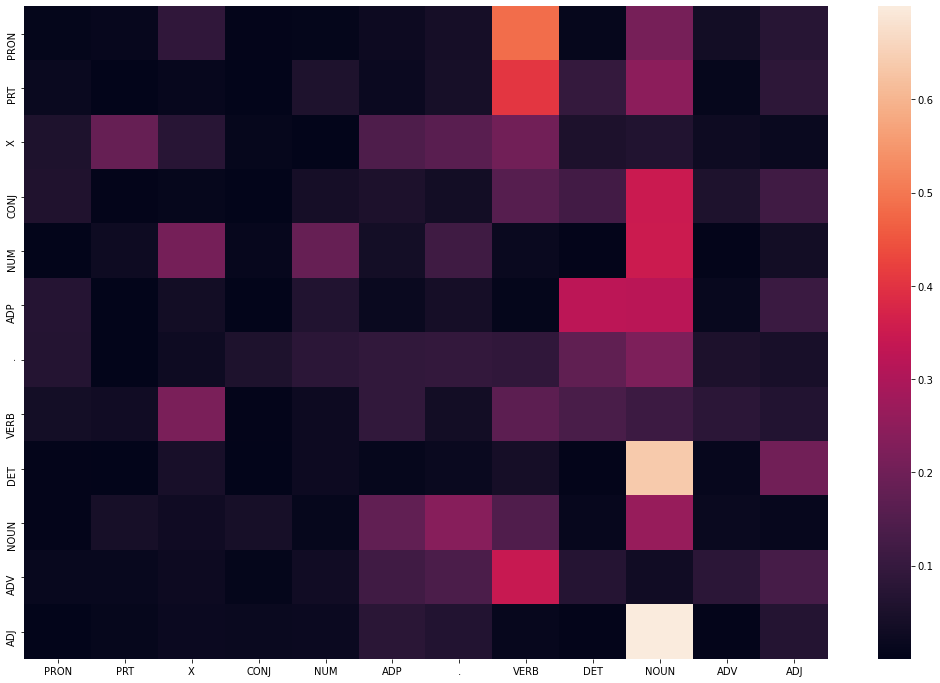

In [178]:
# heatmap of tags matrix
# T(i, j) means P(tag j given tag i)
plt.figure(figsize=(18, 12))
sns.heatmap(tags_df)
plt.show()


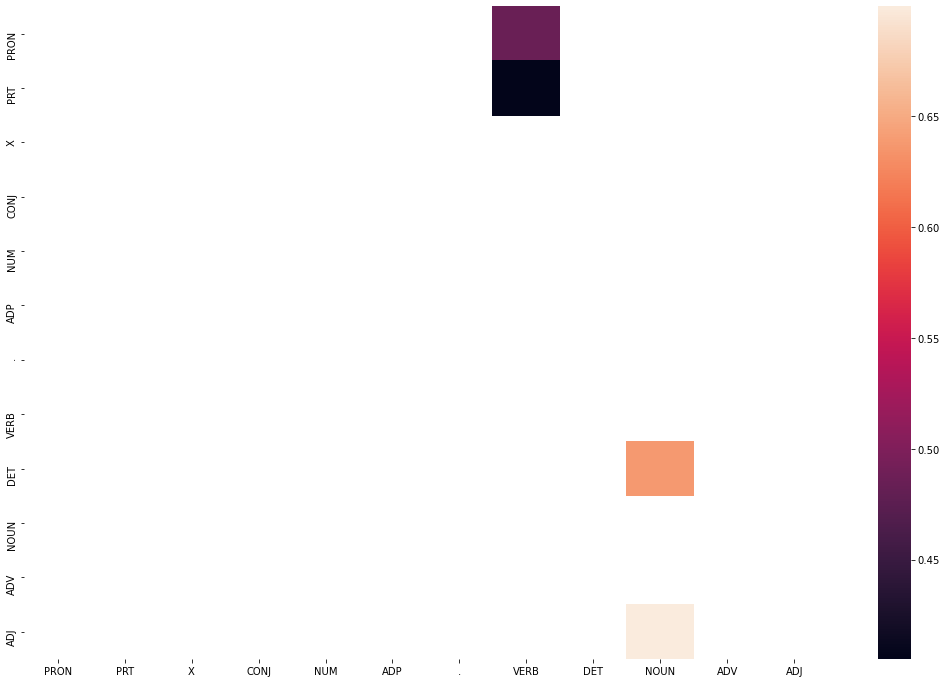

In [188]:
# frequent tags
# filter the df to get P(t2, t1) > 0.4
tags_frequent = tags_df[tags_df>0.4]
plt.figure(figsize=(18, 12))
sns.heatmap(tags_frequent)
plt.show()

### Vanilla Viterbi Algorithm

Steps we follow:

1. Given a sequence of words
2. Iterate all the sequence
    1. For each word calculate the emission probabilties and transition probabilties for possible tags.
    2. Assign the tag which has maximum probability obtained in step 3 above.


In [180]:
# Viterbi Heuristic
def Viterbi(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        # getting state for which probability is maximum
        state_max = T[p.index(pmax)] 
        state.append(state_max)
    return list(zip(words, state))



In [181]:
# Running on entire test dataset would take lots of time . Lets run viterbi on sample sentenace of test set
random.seed(1234)
# choose random 10 sents
rndom = [random.randint(1,len(test_set)) for x in range(10)]

# create a list of sents
test_run = [test_set[i] for i in rndom]

# create a list of tagged words
test_run_base = [tup for sent in test_run for tup in sent]

# create a list of untagged words
test_tagged_words = [tup[0] for sent in test_run for tup in sent]
test_run

[[('The', 'DET'),
  ('Contra', 'NOUN'),
  ('military', 'ADJ'),
  ('command', 'NOUN'),
  (',', '.'),
  ('in', 'ADP'),
  ('a', 'DET'),
  ('statement', 'NOUN'),
  ('from', 'ADP'),
  ('Honduras', 'NOUN'),
  (',', '.'),
  ('said', 'VERB'),
  ('0', 'X'),
  ('Sandinista', 'NOUN'),
  ('troops', 'NOUN'),
  ('had', 'VERB'),
  ('launched', 'VERB'),
  ('a', 'DET'),
  ('major', 'ADJ'),
  ('offensive', 'NOUN'),
  ('against', 'ADP'),
  ('the', 'DET'),
  ('rebel', 'NOUN'),
  ('forces', 'NOUN'),
  ('.', '.')],
 [('*-1', 'X'),
  ('Bucking', 'VERB'),
  ('the', 'DET'),
  ('market', 'NOUN'),
  ('trend', 'NOUN'),
  (',', '.'),
  ('an', 'DET'),
  ('issue', 'NOUN'),
  ('of', 'ADP'),
  ('$', '.'),
  ('130', 'NUM'),
  ('million', 'NUM'),
  ('*U*', 'X'),
  ('general', 'ADJ'),
  ('obligation', 'NOUN'),
  ('distributable', 'ADJ'),
  ('state', 'NOUN'),
  ('aid', 'NOUN'),
  ('bonds', 'NOUN'),
  ('from', 'ADP'),
  ('Detroit', 'NOUN'),
  (',', '.'),
  ('Mich.', 'NOUN'),
  (',', '.'),
  ('apparently', 'ADV'),
  ('drew'

In [182]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

In [183]:
print("Time taken in seconds: ", difference)
print(tagged_seq)

Time taken in seconds:  48.89441657066345
[('The', 'DET'), ('Contra', 'PRON'), ('military', 'ADJ'), ('command', 'VERB'), (',', '.'), ('in', 'ADP'), ('a', 'DET'), ('statement', 'NOUN'), ('from', 'ADP'), ('Honduras', 'PRON'), (',', '.'), ('said', 'VERB'), ('0', 'X'), ('Sandinista', 'PRON'), ('troops', 'NOUN'), ('had', 'VERB'), ('launched', 'VERB'), ('a', 'DET'), ('major', 'ADJ'), ('offensive', 'PRON'), ('against', 'ADP'), ('the', 'DET'), ('rebel', 'PRON'), ('forces', 'VERB'), ('.', '.'), ('*-1', 'X'), ('Bucking', 'PRON'), ('the', 'DET'), ('market', 'NOUN'), ('trend', 'NOUN'), (',', '.'), ('an', 'DET'), ('issue', 'NOUN'), ('of', 'ADP'), ('$', '.'), ('130', 'NUM'), ('million', 'NUM'), ('*U*', 'X'), ('general', 'ADJ'), ('obligation', 'NOUN'), ('distributable', 'ADJ'), ('state', 'NOUN'), ('aid', 'NOUN'), ('bonds', 'NOUN'), ('from', 'ADP'), ('Detroit', 'NOUN'), (',', '.'), ('Mich.', 'NOUN'), (',', '.'), ('apparently', 'ADV'), ('drew', 'PRON'), ('solid', 'ADJ'), ('investor', 'NOUN'), ('interes

In [184]:
# accuracy
accuracy =len( [i for i, j in zip(tagged_seq, test_run_base) if i == j])/len(tagged_seq) 

In [185]:
print('Vanilla Viterbi Algorithm Accuracy: ',accuracy*100)

Vanilla Viterbi Algorithm Accuracy:  89.69957081545064


In [186]:
incorrect_tagged_cases = [[test_run_base[i-1],j] for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0]!=j[1]]

In [187]:
incorrect_tagged_cases

[[('The', 'DET'), (('Contra', 'PRON'), ('Contra', 'NOUN'))],
 [('military', 'ADJ'), (('command', 'VERB'), ('command', 'NOUN'))],
 [('from', 'ADP'), (('Honduras', 'PRON'), ('Honduras', 'NOUN'))],
 [('0', 'X'), (('Sandinista', 'PRON'), ('Sandinista', 'NOUN'))],
 [('major', 'ADJ'), (('offensive', 'PRON'), ('offensive', 'NOUN'))],
 [('the', 'DET'), (('rebel', 'PRON'), ('rebel', 'NOUN'))],
 [('rebel', 'NOUN'), (('forces', 'VERB'), ('forces', 'NOUN'))],
 [('*-1', 'X'), (('Bucking', 'PRON'), ('Bucking', 'VERB'))],
 [('apparently', 'ADV'), (('drew', 'PRON'), ('drew', 'VERB'))],
 [('its', 'PRON'), (('Eveready', 'PRON'), ('Eveready', 'NOUN'))],
 [('what', 'PRON'), (('*T*-252', 'PRON'), ('*T*-252', 'X'))],
 [('*-1', 'X'), (('complaining', 'PRON'), ('complaining', 'VERB'))],
 [('ended', 'VERB'), (('up', 'ADV'), ('up', 'PRT'))],
 [('was', 'VERB'), (('2,303,328', 'PRON'), ('2,303,328', 'NUM'))],
 [('down', 'ADV'), (('2.6', 'PRON'), ('2.6', 'NUM'))],
 [('battle', 'NOUN'), (('opens', 'PRON'), ('opens'

### Solve the problem of unknown words

##### We can see that words are tagged as NOUN and PRON or VERB and PRON. 

### Viterbi Modification Technique I
##### Assign based on transition probabilities only in case of unknown words as emission probability for unknown word is zero.

In [189]:
# use transition probability of tags when emission probability is zero (in case of unknown words)
def Viterbi_1(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [190]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_1(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Time(seconds):  46.155325412750244
Modified Viterbi_1 Accuracy:  94.84978540772532


### Adding Tag occurance probability weights:

We will apply weights based on the probability of tag occurance to the transition probabilities of tags and then use the resulting probability for predicting unknown words.

In [191]:
# lets start creating a list of tuples of POS tags and occurance probability, basis on training data
tag_prob = []
total_tag = len([tag for word,tag in train_tagged_words])
for t in tags:
    each_tag = [tag for word,tag in train_tagged_words if tag==t]
    tag_prob.append((t,len(each_tag)/total_tag))

tag_prob

[('PRON', 0.0273373313657153),
 ('PRT', 0.03176447193527793),
 ('X', 0.06576867928872701),
 ('CONJ', 0.02251248076862696),
 ('NUM', 0.035145007169246546),
 ('ADP', 0.0978889970381069),
 ('.', 0.11641391147812072),
 ('VERB', 0.1351167488251855),
 ('DET', 0.08666938784053921),
 ('NOUN', 0.2862674913916711),
 ('ADV', 0.031597015081582885),
 ('ADJ', 0.06351847781719991)]

In [192]:
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # list for storing transition probabilities
       
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p             
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = T[p.index(pmax)] 
        
      
        # if probability is zero (unknown word) then use weighted transition probability
        if(pmax==0):
            pmax = max(p_transition)
            state_max = T[p_transition.index(pmax)]                 
                           
        else:
            state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [193]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_1 Accuracy: ',accuracy*100)

Time(seconds):  57.91104054450989
Modified Viterbi_1 Accuracy:  95.70815450643777


#### There is no such much difference in accuracy by weighted transition probabilties. But very much difference in vanila based viterbi accuracy and after appliying techniques.

In [194]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('Sandinista', 'VERB'), ('Sandinista', 'NOUN')),
 (('Eveready', 'VERB'), ('Eveready', 'NOUN')),
 (('*T*-252', 'VERB'), ('*T*-252', 'X')),
 (('up', 'ADV'), ('up', 'PRT')),
 (('2,303,328', 'NOUN'), ('2,303,328', 'NUM')),
 (('2.6', 'VERB'), ('2.6', 'NUM')),
 (('opens', 'NOUN'), ('opens', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('borrowing', 'VERB'), ('borrowing', 'NOUN'))]

The following  few of words have been **correctly POS tagged by Viterbi_2** as compared to vanilla Viterbi Algorithm:

* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB

### Viterbi Modification-Technique II

* Backoff to rule based tagger in case of unknown words.
* The above technique is modified by using transition probability in approach 2 above if rule based tagger returns default noun tag ('NOUN').

In [195]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'.*', 'NOUN')                   # nouns
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [196]:
# Modification in Viterbi Algorithm : Backoff to rule based tagger in case unknown word is encountered.
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1]       
       
        
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
        else:
            if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)]                
            
        
        state.append(state_max)
    return list(zip(words, state))

In [197]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

Time(seconds):  49.65159201622009


In [198]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 Accuracy: ',accuracy*100)

Modified Viterbi_2 Accuracy:  96.99570815450643


### We got better accuracy then 1st technique

In [199]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('drew', 'NOUN'), ('drew', 'VERB')),
 (('up', 'ADV'), ('up', 'PRT')),
 (('2,303,328', 'NOUN'), ('2,303,328', 'NUM')),
 (('opens', 'NOUN'), ('opens', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('borrowing', 'VERB'), ('borrowing', 'NOUN'))]

The following list of words have been correctly POS tagged by Viterbi_2 as compared to vanilla Viterbi Algorithm:

* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB

### Lets modify viterb 2nd technique 

We know that the rule based tagger assigns 'NOUN' by default, to correct this assign the tags for any this type words on transition probability of tags.

Let modify the rule based tagger to output 'NN' instead of 'NOUN' in above case. We also observe that any capitalized word can still be defaulted as 'NOUN' so will add one more rule for that case.

In [200]:
# specify patterns for tagging
patterns = [
    (r'.*ing$', 'VERB'),              # gerund
    (r'.*ed$', 'VERB'),               # past tense 
    (r'.*es$', 'VERB'),               # verb    
    (r'.*\'s$', 'NOUN'),              # possessive nouns
    (r'.*s$', 'NOUN'),                # plural nouns
    (r'\*T?\*?-[0-9]+$', 'X'),        # X
    (r'^-?[0-9]+(.[0-9]+)?$', 'NUM'), # cardinal numbers
    (r'^[A-Z][a-z].*', 'NOUN'),       # NOUN
    (r'.*', 'NN')                     # default
]

# rule based tagger
rule_based_tagger = nltk.RegexpTagger(patterns)

In [201]:
# modified Viterbi
def Viterbi_2(words, train_bag = train_tagged_words):
    state = []
    T = list(set([pair[1] for pair in train_bag]))
    
    for key, word in enumerate(words):
        #initialise list of probability column for a given observation
        p = [] 
        p_transition =[] # for storing transition probabilities
        for tag in T:
            if key == 0:
                transition_p = tags_df.loc['.', tag]
            else:
                transition_p = tags_df.loc[state[-1], tag]
                
            # compute emission and state probabilities
            emission_p = word_given_tag(words[key], tag)[0]/word_given_tag(words[key], tag)[1]
            state_probability = emission_p * transition_p    
            p.append(state_probability)
            
            # find POS tag occurance probability
            tag_p = [pair[1] for pair in tag_prob if pair[0]==tag ]
            
            # calculate the transition prob weighted by tag occurance probability.
            transition_p = tag_p[0]*transition_p
            p_transition.append(transition_p)
            
        pmax = max(p)
        state_max = rule_based_tagger.tag([word])[0][1] 
        
      
        # getting state for which probability is maximum
        if(pmax==0):
            state_max = rule_based_tagger.tag([word])[0][1] # assign based on rule based tagger
            
            # if unknown word does not satisfy any rule, find the tag with maximum transition probability
            if state_max == 'NN':
                pmax = max(p_transition)
                state_max = T[p_transition.index(pmax)]                 
                
        else:
             if state_max != 'X':
                # getting state for which probability is maximum
                state_max = T[p.index(pmax)] 
        
        state.append(state_max)
    return list(zip(words, state))

In [202]:
# tagging the test sentences
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

Time(seconds):  55.88675022125244


In [203]:
# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi_2 Algorithm Accuracy: ',accuracy*100)

Modified Viterbi_2 Algorithm Accuracy:  97.42489270386267


### We can see much better accuracy now.

In [204]:
# let's check the incorrectly tagged words
[j for i, j in enumerate(zip(tagged_seq, test_run_base)) if j[0] != j[1]]

[(('command', 'VERB'), ('command', 'NOUN')),
 (('up', 'ADV'), ('up', 'PRT')),
 (('2,303,328', 'NOUN'), ('2,303,328', 'NUM')),
 (('opens', 'NOUN'), ('opens', 'VERB')),
 (('that', 'ADP'), ('that', 'DET')),
 (('borrowing', 'VERB'), ('borrowing', 'NOUN'))]

The following list of words have been correctly POS tagged by Viterbi_2 as compared to vanilla Viterbi Algorithm:
* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB

the following list of words has been correctly tagged by Viterbi_2 as compared to Viterbi_1
* Sandinista: correctly tagged as NOUN
* Eveready: correctly tagged as NOUN
* `*T*-252`: correctly tagged as 'X'
* borrowing: correctly tagged as VERB

#### Evaluate vanilla and modified Viterbi on test data

In [205]:
test_tagged_words = [tup[0] for sent in test_set for tup in sent]
test_run_base = [tup for sent in test_set for tup in sent]

In [206]:
# tagging the all test sentences. All tagged sentences takes more than 20 minutes. If want to make it fast test this model 
# only on few test tagged words
start = time.time()
tagged_seq = Viterbi(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Vanilla Viterbi Algorithm Accuracy: ',accuracy*100)

Time(seconds):  1121.2147216796875
Vanilla Viterbi Algorithm Accuracy:  90.89491128875025


In [207]:
# Tagging the all test sentences. All tagged sentences takes more than 20 minutes. If want to make it fast test this model 
# only on few test tagged words
start = time.time()
tagged_seq = Viterbi_2(test_tagged_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

# accuracy
check = [i for i, j in zip(tagged_seq, test_run_base) if i == j] 
accuracy = len(check)/len(tagged_seq)
print('Modified Viterbi Algorithm Accuracy: ',accuracy*100)

Time(seconds):  1061.740980386734
Modified Viterbi Algorithm Accuracy:  95.43770715539091


#### Evaluating tagging on sample 'Test_sentences.txt' file

In [209]:
f = open('Test_sentences.txt')

In [210]:
text = f.read()

In [211]:
test_sent = text.splitlines()

In [212]:
f.close()

In [213]:
sample_test_sent = test_sent[:3]

In [214]:
sample_test_sent

['Android is a mobile operating system developed by Google.',
 'Android has been the best-selling OS worldwide on smartphones since 2011 and on tablets since 2013.',
 "Google and Twitter made a deal in 2015 that gave Google access to Twitter's firehose."]

In [215]:
# list of untagged words
sample_test_words = [word for sent in test_sent for word in sent.split()]

In [216]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi(sample_test_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

Time taken in seconds:  36.23003339767456


In [217]:
sample_tagged_seq

[('Android', 'PRON'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'PRON'),
 ('Android', 'PRON'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'PRON'),
 ('worldwide', 'PRON'),
 ('on', 'ADP'),
 ('smartphones', 'PRON'),
 ('since', 'ADP'),
 ('2011', 'PRON'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'PRON'),
 ('Google', 'PRON'),
 ('and', 'CONJ'),
 ('Twitter', 'PRON'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'PRON'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'PRON'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'PRON'),
 ('firehose.', 'PRON'),
 ('Twitter', 'PRON'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'PRON'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'D

We can see that several words have been misclassified by vanilla Viterbi POS tagger, for example:

* Android as PRON
* Google as PRON
* Twitter as PRON

In [219]:
# tagging the test sentences
start = time.time()
sample_tagged_seq = Viterbi_2(sample_test_words)
end = time.time()
difference = end-start

print("Time(seconds): ", difference)

Time(seconds):  35.33794665336609


In [220]:
sample_tagged_seq

[('Android', 'NOUN'),
 ('is', 'VERB'),
 ('a', 'DET'),
 ('mobile', 'ADJ'),
 ('operating', 'NOUN'),
 ('system', 'NOUN'),
 ('developed', 'VERB'),
 ('by', 'ADP'),
 ('Google.', 'NOUN'),
 ('Android', 'NOUN'),
 ('has', 'VERB'),
 ('been', 'VERB'),
 ('the', 'DET'),
 ('best-selling', 'ADJ'),
 ('OS', 'NOUN'),
 ('worldwide', 'NOUN'),
 ('on', 'ADP'),
 ('smartphones', 'VERB'),
 ('since', 'ADP'),
 ('2011', 'NUM'),
 ('and', 'CONJ'),
 ('on', 'ADP'),
 ('tablets', 'NOUN'),
 ('since', 'ADP'),
 ('2013.', 'NOUN'),
 ('Google', 'NOUN'),
 ('and', 'CONJ'),
 ('Twitter', 'NOUN'),
 ('made', 'VERB'),
 ('a', 'DET'),
 ('deal', 'NOUN'),
 ('in', 'ADP'),
 ('2015', 'NUM'),
 ('that', 'ADP'),
 ('gave', 'VERB'),
 ('Google', 'NOUN'),
 ('access', 'NOUN'),
 ('to', 'PRT'),
 ("Twitter's", 'NOUN'),
 ('firehose.', 'NOUN'),
 ('Twitter', 'NOUN'),
 ('is', 'VERB'),
 ('an', 'DET'),
 ('online', 'NOUN'),
 ('news', 'NOUN'),
 ('and', 'CONJ'),
 ('social', 'ADJ'),
 ('networking', 'NOUN'),
 ('service', 'NOUN'),
 ('on', 'ADP'),
 ('which', 'DET

All these cases were correctly POS tagged by Viterbi_2:
* Android as NOUN
* Google as NOUN
* Twitter as NOUN

### Compare the tagging accuracies of the modifications with the vanilla Viterbi algorithm

The accuracy of vanilla Viterbi Algorithm: **90.88%**

The accuracy of modified Viterbi Algorithm: **95.61%**

### List down cases which were incorrectly tagged by original POS tagger and got corrected by your modifications

The following cases were incorrectly tagged which got corrected by modified Viterbi Algorithm:

* Contra:correctly tagged as NOUN
* Honduras:correctly tagged as NOUN
* complaining: correctly tagged as VERB
* Bucking: correctly tagged as VERB
* Sandinista: correctly tagged as NOUN
* Eveready: correctly tagged as NOUN
* `*T*-252`: correctly tagged as 'X'
* drew: correctly tagged as VERB